In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 12.4: Posterior Predictive Checking

## Objectives

+ Introduce the concept of posterior predictive checking

## Posterior Predictive Checking

Assume that we have built a model using some data, say $x_{1:n}$.
Now, assume that you do the experiment again under the same conditions.
What data does your model tell you that you would observe?
The posterior predictive distribution of the *replicated data* $x^{\text{rep}}_{1:n}$ is simply:
$$
p(x^{\text{rep}}_{1:n}|x_{1:n}) = \int p(x^{\text{rep}}_{1:n}|\theta)p(\theta|x_{1:n})d\theta,
$$
where $p(x^{\text{rep}}_{1:n}|\theta)$ is just the likelihood and $p(\theta|x_{1:n})$ the posterior.
The idea of *posterior predictive checking* is to repeatedly sample $x^{\text{rep}}_{1:n}$ and compare their characteristics to the true data.
You may reject a model that performs very poorly under predictive checking.
However, you cannot accept a model that performs very well.
There are other methods for doing this which are more involved.
Predictive checking is good for identifying bugs in your code or coming up with ideas to extend the models in a way that better matches the data.

## Visual Inspections of Replicated Data

The idea here is to simply sample $x^{\text{rep}}_{1:n}$ and compare it visually to $x_{1:n}$.
Let's see this on the coin toss example.

## Demonstration with the Coin Toss Example

Consider $n$ coin-tosses with probability of heads ($1$) $\theta$, i.e.,
$$
x_{i}|\theta \sim \operatorname{Ber}(\theta).
$$
We put a uniform prior on $\theta$:
$$
\theta\sim U([0,1]),
$$
and we have already seen that the posterior is a Beta:
$$
\theta|x_{1:n} \sim \operatorname{Beta}\left(1 + \sum_{i=1}^nx_i, 1 + n - \sum_{i=1}^nx_i\right).
$$
Now, it is actually possible to get $p(x^{\text{rep}}_{1:n} | x_{1:n})$ analytically in this case.
However, we will not bother doing it.
We can simply sampling from it as follows:
+ First, sample a $\theta$ from the posterior $p(\theta|x_{1:n})$.
+ Second, sample a $x^{\text{rep}}$ from the likelihood $p(x^{\text{rep}}|\theta)$.
+ Repeat steps one and two as many times as needed.

Ok, let's start with a dataset that is 100\% known that it is compatible from the model because we are simply simulating it.
Here you go:

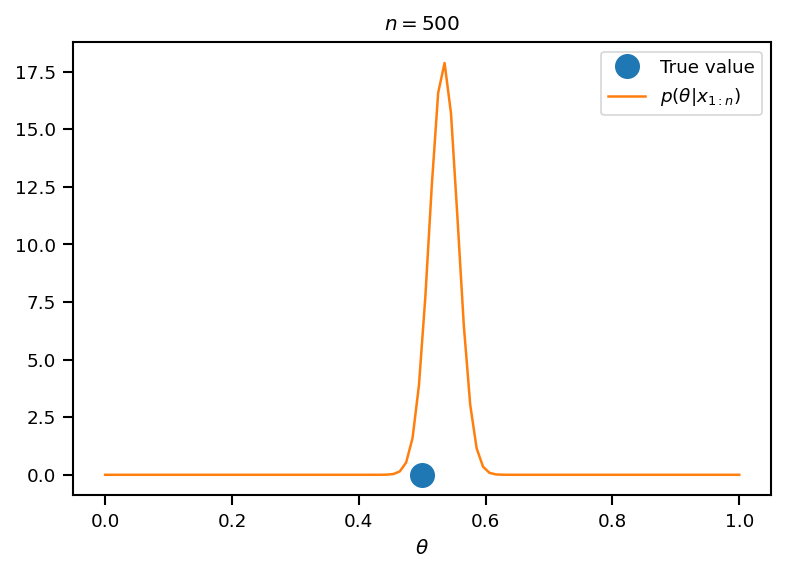

In [16]:
import scipy.stats as st
# Take a fake coin which is a little bit biased - Presumably unknown to us
theta_true = 0.5
# Here is the underlying random variable from which we will sample
X = st.bernoulli(theta_true)
# Sample from it a number of times to generate our y = (y1, ..., xn)
n = 500
x = X.rvs(size=n)
# Now we are ready to calculate the posterior which the Beta we have above
alpha = 1.0 + x.sum()
beta = 1.0 + n - x.sum()
Theta_post = st.beta(alpha, beta)
# Now we can plot the posterior PDF for theta
fig, ax = plt.subplots(dpi=150)
thetas = np.linspace(0, 1, 100)
ax.plot([theta_true], [0.0], 'o', markeredgewidth=2, markersize=10, label='True value')
ax.plot(thetas, Theta_post.pdf(thetas), label=r'$p(\theta|x_{1:n})$')
ax.set_xlabel(r'$\theta$')
ax.set_title('$n={0:d}$'.format(n))
plt.legend(loc='best')

Now that we have fitted the model, let's draw many replicated data $y^{\text{rep}}$ from the posterior predictive and compare them to the original dataset.

In [17]:
# Draw replicated data
n_rep = 9
x_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_post_sample = Theta_post.rvs()
    x_rep[i, :] = st.bernoulli(theta_post_sample).rvs(size=n)

We can visualize the data as images.
The first row of pixels is are the observed data.

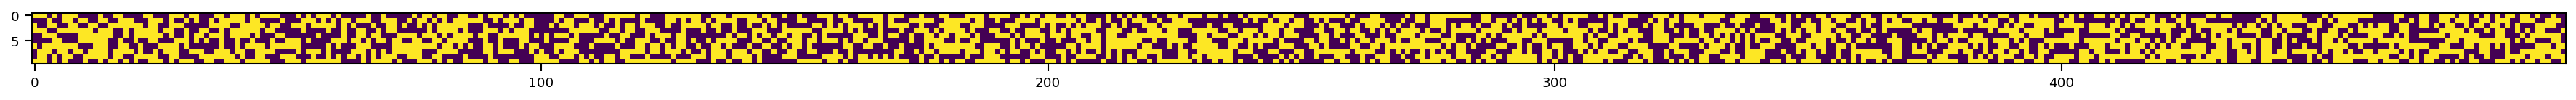

In [18]:
fig, ax = plt.subplots(figsize=(30, 10), dpi=150)
ax.imshow(np.vstack([x, x_rep]));

This visual inspection does not reveal anything strange.
Let's now repeat this excersize with a dataset that is completely artificial and does not match the model.
This a dataset that we are making by hand trying to emulate a coin toss with probability of heads equal to $0.8$:

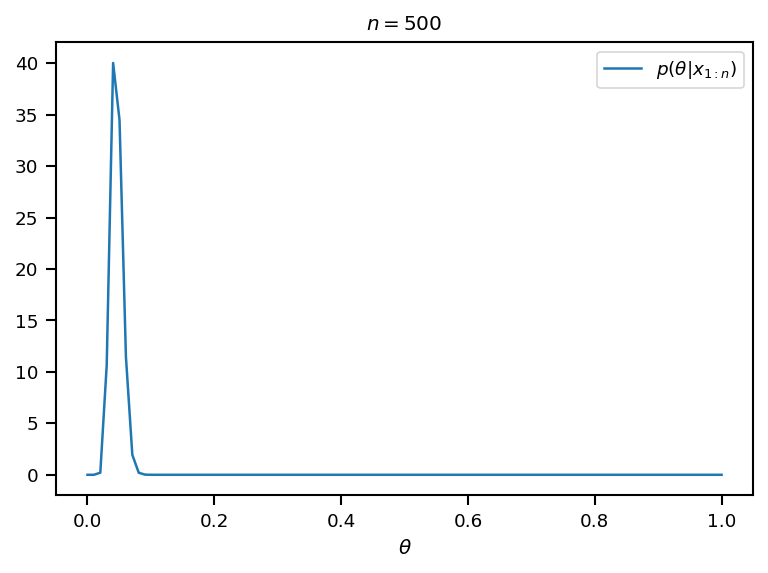

In [19]:
x_2 = np.array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])
alpha_2 = 1.0 + x_2.sum()
beta_2 = 1.0 + n - x_2.sum()
Theta_2_post = st.beta(alpha_2, beta_2)
# Now we can plot the posterior PDF for theta
fig, ax = plt.subplots(dpi=150)
thetas = np.linspace(0, 1, 100)
ax.plot(thetas, Theta_2_post.pdf(thetas), label=r'$p(\theta|x_{1:n})$')
ax.set_xlabel(r'$\theta$')
ax.set_title('$n={0:d}$'.format(n))
plt.legend(loc='best')

There is no true value for $\theta$ here as I actually picked the data by hand.
Let's see if the visual comparison to replicated data reveals that the data did not really come from a fair coin.

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 1 has size 500

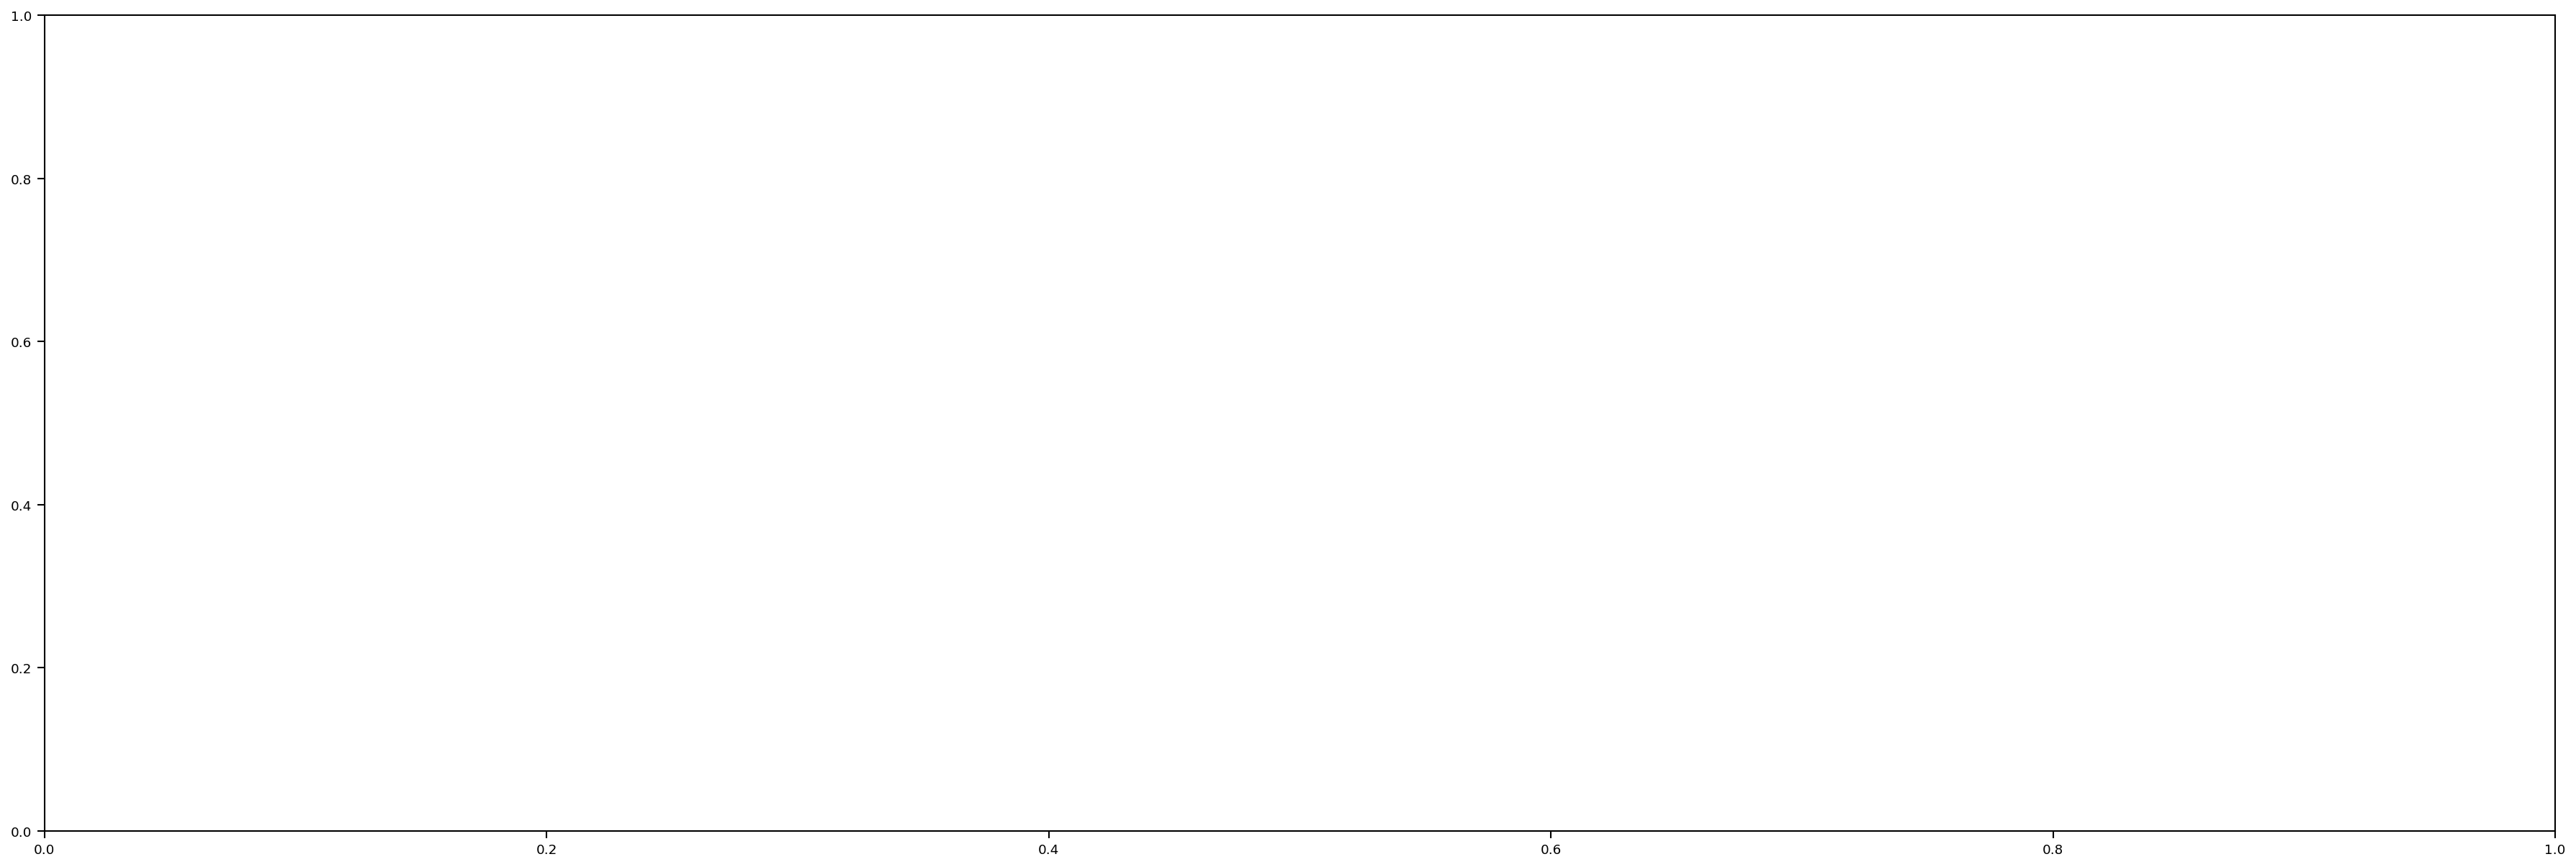

In [20]:
# Draw replicated data
n_rep = 9
x_2_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_2_post_sample = Theta_2_post.rvs()
    x_2_rep[i, :] = st.bernoulli(theta_2_post_sample).rvs(size=n)
fig, ax = plt.subplots(figsize=(30, 10), dpi=150)
ax.imshow(np.vstack([x_2, x_2_rep]));

If you pay close attention you will notice that the data I picked by hand has more transitions from heads to tails than the replicated data.
In other words, the replicated data seem to have longer consecutive series of either heads or tails.
How can we see this more clearly?

### Test quantities and visual inspections

We use *test quantities* to characterize the discrepancy between the model and the data.
In particular, test quantities help us zoom into the characteristsics of the data that are of particular interest to us.
Mathematically, a test quantity is a scalar function of the data and the model parameters $T(x_{1:n},\theta)$.
There are some general recipies for creating test quantities for regression and classification.
However, in general, you must use common sense in selecting them.
What are the important characteristics of the data that your model should be capturing.
We will be seeing specific examples below.

Now, assume that you have selected one, or more, test quantities.
What do you do with them?
Well, the easiest thing to do is a visual comparison of the histogram of the test quantity over replicated data, i.e., of
$p(T(x^{\text{rep}}_{1:n},\theta) | x_{1:n})$, and compare it to the observe value $T(x_{1:n},\theta)$.
In these plots you are trying to see how likely or unlikely is observed test quantity according to your model.
We will be visualizing them next for the coin toss example.

### Test quantities and Bayesian $p$-values

Antother thing that you can do to check your model is to evaluate the probability that the replicated data give you a test quantity that is more extreme than the observed value.
This probability is known as the posterior (or Bayesian) $p$-value and it is defined by:
$$
p_B = \mathbb{P}(T(x^{\text{rep}}_{1:n},\theta) > T(x_{1:n},\theta) | x_{1:n}) = \int 1_{[T(x_{1:n},\theta),\infty]}(T(x^{\text{rep}}_{1:n})) p(x^{\text{rep}}_{1:n}, \theta|x_{1:n}) dx^{\text{rep}}_{1:n}d\theta.
$$
Of course, you can just estimate the Bayesian $p$-value using Monte Carlo sampling from the joint posterior of $x^{\text{rep}}_{1:n}$ and $\theta$ conditioned on the data $x_{1:n}$.

How should I interpret the Bayesian $p$-values?
**It is not the probability that your model is correct.**
We will derive this probability in the Bayesian model selection lecture.
The Bayesian $p$-value is the probability that replications of the experiment will yield test quantitys that exceed the observed value under the assumption that your model is correct.
So, here is a nice way to interpret them:
+ A Bayesian $p$-value close to $0$ or $1$ indicates that the observed test quantity is unlikely under the assumption that your model is correct. So your model does not capture this aspect of the data. You probably need expand/modify your model somehow.

## Back to the coin toss example

What are some good test quantities that we can pick for this example.
An obvious one is the number of heads.
This is only a function of the data.
It is:
$$
T_{h}(x_{1:n}) = \sum_{i=1}^nx_i.
$$
Let's implement this as a Python function of the data:

In [7]:
def T_h(x):
    """
    This is an implementation of a 
    """
    return x.sum()

Remember, that we have run this example with two datasets: one that was generated from the correct model and one that was generated by hand.
We will see the results that we get from both.
For the first dataset (the one generated by the model) we get:

The observed test quantity is 29
The Bayesian p_value is 0.4600


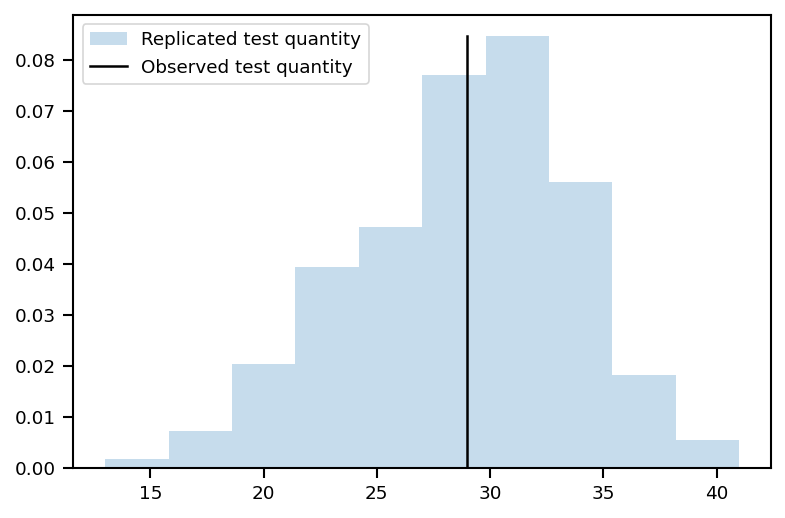

In [8]:
# The observed test quantity
T_h_obs = T_h(x)
print('The observed test quantity is {0:d}'.format(T_h_obs))
# Draw replicated data
n_rep = 1000
x_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_post_sample = Theta_post.rvs()
    x_rep[i, :] = st.bernoulli(theta_post_sample).rvs(size=n)
# Evaluate the test quantity
T_h_rep = np.ndarray(x_rep.shape[0])
for i in range(x_rep.shape[0]):
    T_h_rep[i] = T_h(x_rep[i, :])
# Estimate the Bayesian p-value
p_val = np.sum(np.ones((n_rep,))[T_h_rep > T_h_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_rep, density=True, alpha=0.25, label='Replicated test quantity')[0]
ax.plot(T_h_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

Now, let's look also at the other dataset (the one we picked by hand):

The observed test quantity is 22
The Bayesian p_value is 0.4480


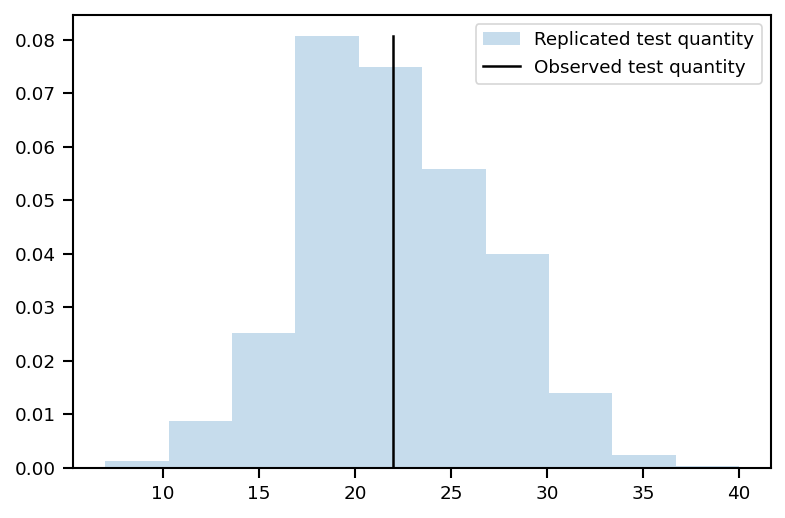

In [9]:
# The observed test quantity
T_h_2_obs = T_h(x_2)
print('The observed test quantity is {0:d}'.format(T_h_2_obs))
# Draw replicated data
n_rep = 1000
x_2_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_2_post_sample = Theta_2_post.rvs()
    x_2_rep[i, :] = st.bernoulli(theta_2_post_sample).rvs(size=n)
# Evaluate the test quantity
T_h_2_rep = np.ndarray(x_2_rep.shape[0])
for i in range(x_rep.shape[0]):
    T_h_2_rep[i] = T_h(x_2_rep[i, :])
# Estimate the Bayesian p-value
p_val_2 = np.sum(np.ones((n_rep,))[T_h_2_rep > T_h_2_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val_2))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_2_rep, density=True, alpha=0.25, label='Replicated test quantity')[0]
ax.plot(T_h_2_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

It looks about the same. This just means that I was able to replicate this particular test quantity when I picked values by hand.
Can we find a better statistic?
Remember our observation when we plotted the replicated data vs the true data for the second case.
We observed that my hand-picked data included more transitions from heads to tails.
Let's build a statistic that captures that.
We are going to take this:
$$
T_s(x) = \text{# number of switches from 0 and 1 in the sequence}\;x.
$$
This is not easy to write in an analytical form, but we can program it:

In [10]:
def T_s(x):
    s = 0
    for i in range(1, x.shape[0]):
        if x[i] != x[i-1]:
            s += 1
    return s

Let's look first at the original dataset:

In [1]:
# The observed test quantity
T_s_obs = T_s(x)
print('The observed test quantity is {0:d}'.format(T_s_obs))
# Draw replicated data
n_rep = 1000
x_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_post_sample = Theta_post.rvs()
    x_rep[i, :] = st.bernoulli(theta_post_sample).rvs(size=n)
# Evaluate the test quantity
T_s_rep = np.ndarray(x_rep.shape[0])
for i in range(x_rep.shape[0]):
    T_s_rep[i] = T_s(x_rep[i, :])
# Estimate the Bayesian p-value
p_val = np.sum(np.ones((n_rep,))[T_s_rep > T_s_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_rep, density=True, alpha=0.25, label='Replicated statistic')[0]
#ax.plot(T_s_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

NameError: name 'T_s' is not defined

This looks okay. 

Let's now look at the one I picked by hand:

The observed test quantity is 36
The Bayesian p_value is 0.0010


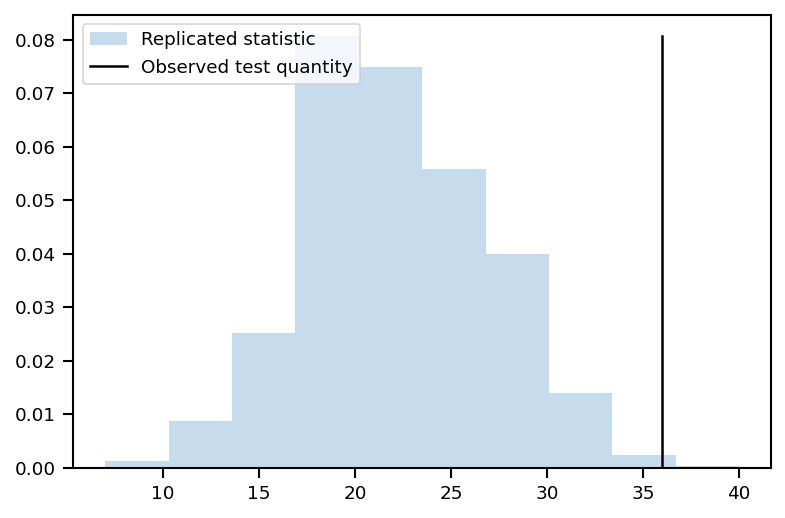

In [12]:
# The observed test quantity
T_s_2_obs = T_s(x_2)
print('The observed test quantity is {0:d}'.format(T_s_2_obs))
# Draw replicated data
n_rep = 1000
x_2_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_2_post_sample = Theta_2_post.rvs()
    x_2_rep[i, :] = st.bernoulli(theta_2_post_sample).rvs(size=n)
# Evaluate the test quantity
T_s_2_rep = np.ndarray(x_2_rep.shape[0])
for i in range(x_rep.shape[0]):
    T_s_2_rep[i] = T_s(x_2_rep[i, :])
# Estimate the Bayesian p-value
p_val_2 = np.sum(np.ones((n_rep,))[T_s_2_rep > T_s_2_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val_2))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_2_rep, density=True, alpha=0.25, label='Replicated statistic')[0]
ax.plot(T_s_2_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

The data are highly unlikely under the assumptions of this model.

## Questions
+ Rerun all the steps above with a larger number $N$ of coin toss observations.